# Chapter 11 - Recap

## Binomial regression

In [1]:
library(rethinking)

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Loading required package: parallel

rethinking (Version 2.13)


Attaching package: ‘rethinking’


The following object is masked from ‘package:stats’:

    rstudent




In [2]:
data(chimpanzees)
d <- chimpanzees

In [3]:
?chimpanzees

chimpanzees {rethinking},R Documentation


In [4]:
d$treatment <- 1 + d$prosoc_left + 2*d$condition

In [5]:
xtabs(~ treatment + prosoc_left + condition, d)

, , condition = 0

         prosoc_left
treatment   0   1
        1 126   0
        2   0 126
        3   0   0
        4   0   0

, , condition = 1

         prosoc_left
treatment   0   1
        1   0   0
        2   0   0
        3 126   0
        4   0 126


#### A first model definition with a "flat" prior for a

In [7]:
m11.1 <- quap(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p) <- a,
        a ~ dnorm(0, 10)
    ), data=d
)

`pulled_left` indicates that the chimp pulled the left handle.

#### Simulating from the prior

In [8]:
set.seed(1999)
prior <- extract.prior(m11.1, n=1e4)

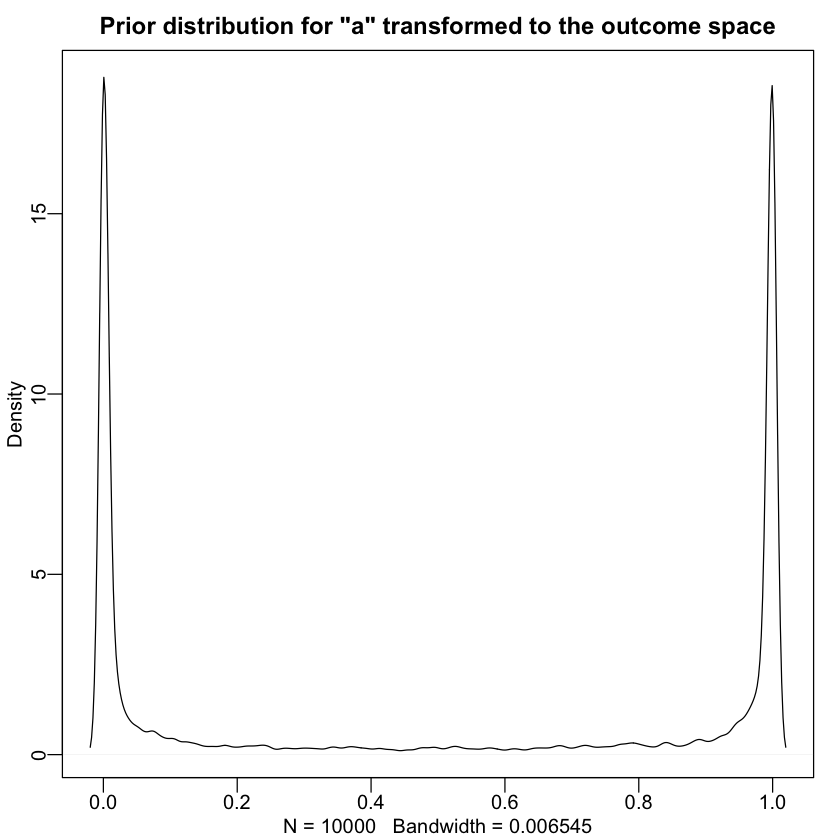

In [13]:
p <- inv_logit(prior$a)
dens(p, adj=0.1, main='Prior distribution for "a" transformed to the outcome space')

Looking at the prior distribution, before seeing the data, the model assumes that the chimps will always or never pull the left handle. So when using link functions, flat priors in the input space are not always flat priors in the outcome space.

### Another model with flat priors for a and b

In [16]:
m11.3 <- quap(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p)  <- a + b[treatment],
        a ~ dnorm(0, 1.5),
        b[treatment] ~ dnorm(0, 0.5)
    ), data=d
)
set.seed(1999)
prior <- extract.prior(m11.3, n=1e4)

In [19]:
str(prior)

List of 2
 $ a: num [1:10000(1d)] 1.099 -0.0567 1.8045 2.2047 0.2005 ...
 $ b: num [1:10000, 1:4] 0.117 -0.573 0.227 0.702 -0.449 ...
 - attr(*, "source")= chr "quap prior: 10000 samples from m11.3"


In [15]:
p <- sapply(1:4, function(k) inv_logit(prior$a + prior$b[,k]))

`p` is a matrix that holds samples for the probability of the chimpanzee to pull the left handle given one of four treatments. Probabilities are transformed to the outcome space.

In [21]:
head(p)

0.7713979,0.8049984,0.7137373,0.7676945
0.3476301,0.8053233,0.5288471,0.6541690
0.8840334,0.8988298,0.7884155,0.8116421
0.9481954,0.7352721,0.9323378,0.9408123
0.4383109,0.5773124,0.5566019,0.6365602
0.8007519,0.5696762,0.6684508,0.6935776


Now we want to know the average difference between the probability of the chimps to pull the left handle between treatments.

In [15]:
mean(abs(p[, 1] - p[, 2]))

[1] 0.09838663

The priors chosen in m11.3 are flat also in the transformed outcome space

### Hamiltonian Monte Carlo

In [22]:
dat_list <- list(
    pulled_left=d$pulled_left,
    actor=d$actor,
    treatment=as.integer(d$treatment)
)

In [23]:
options(mc.cores = parallel::detectCores())

In [27]:
m11.4 <- ulam(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p) <- a[actor] + b[treatment],
        a[actor] ~ dnorm(0, 1.5),
        b[treatment] ~ dnorm(0, 0.5)
    ), data=dat_list, chains=4, log_lik=TRUE

)


SAMPLING FOR MODEL '82480dff1a626a42c2ca9de938d65b9d' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000114 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.14 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:   1 / 1000 [  0%]  (Warmup)
Chain 1: Iteration: 100 / 1000 [ 10%]  (Warmup)
Chain 1: Iteration: 200 / 1000 [ 20%]  (Warmup)
Chain 1: Iteration: 300 / 1000 [ 30%]  (Warmup)
Chain 1: Iteration: 400 / 1000 [ 40%]  (Warmup)
Chain 1: Iteration: 500 / 1000 [ 50%]  (Warmup)
Chain 1: Iteration: 501 / 1000 [ 50%]  (Sampling)
Chain 1: Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain 1: Iteration: 700 / 1000 [ 70%]  (Sampling)
Chain 1: Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain 1: Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain 1: Iteration: 1000 / 1000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.49053 seconds (Warm-up)
Chain 1:                0.383273 seconds (Sampling)
Chain 1:   

In [28]:
precis(m11.4, depth=2)

,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a[1],-0.42878150,0.3342138,-0.94906783,0.11815917,672.2653,1.004924
a[2],3.93107324,0.7602115,2.83349513,5.22246780,1300.7738,1.001702
a[3],-0.72836642,0.3436646,-1.28993673,-0.17879044,844.5166,1.000267
a[4],-0.73107065,0.3446613,-1.30571195,-0.20065266,702.3799,1.003187
a[5],-0.42729720,0.3318995,-0.95139054,0.09454480,655.9572,1.002675
a[6],0.50386417,0.3420611,-0.05230458,1.04903793,665.2975,1.003914
a[7],1.97708463,0.4254668,1.28774926,2.65231310,682.8315,1.006864
b[1],-0.05687998,0.2875033,-0.50302618,0.41006017,602.2589,1.003733
b[2],0.46110431,0.2968568,-0.00997736,0.94910189,669.0463,1.002660


**Recap:**  
`n_eff` is an estimator for the number of independent samples you managed to get. Here, the number of efficient samples is much smaller (1/4th) than the actual number of samples, which means that the samples are autocorrelated to some degree.

`Rhat` measures whether the chain converges towards the true shape of the posterior. As it is almost 1 for all parameters, this is the case.

In [29]:
show(m11.4)

Hamiltonian Monte Carlo approximation
2000 samples from 4 chains

Sampling durations (seconds):
        warmup sample total
chain:1   0.49   0.38  0.87
chain:2   0.53   0.48  1.00
chain:3   0.51   0.41  0.92
chain:4   0.51   0.51  1.03

Formula:
pulled_left ~ dbinom(1, p)
logit(p) <- a[actor] + b[treatment]
a[actor] ~ dnorm(0, 1.5)
b[treatment] ~ dnorm(0, 0.5)


#### Baseline for each chimp

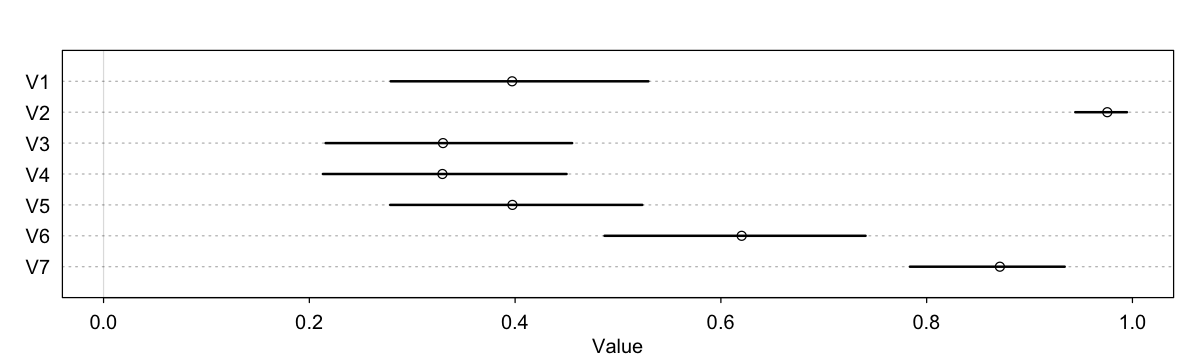

In [33]:
options(repr.plot.width=10, repr.plot.height=3)
post <- extract.samples(m11.4)
p_left <- inv_logit(post$a)
plot(precis(as.data.frame(p_left)), xlim=c(0, 1))

#### Treatment effects

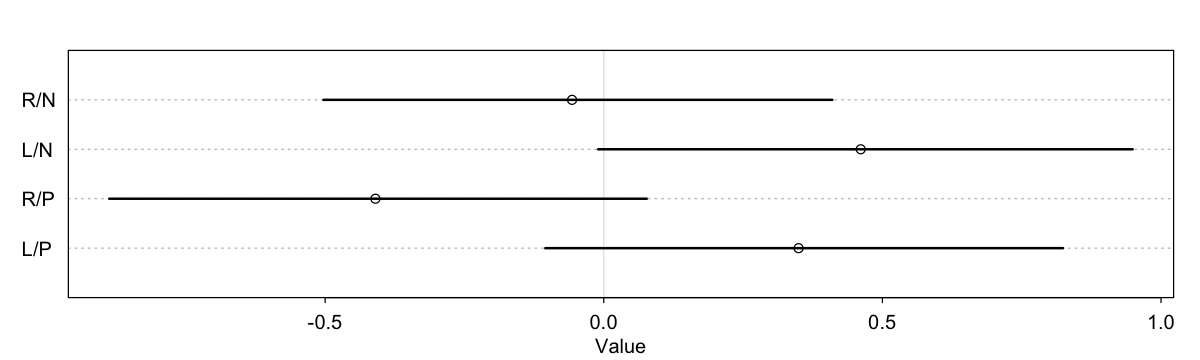

In [34]:
labs <- c("R/N", "L/N", "R/P", "L/P")
plot(precis(m11.4, depth=2, pars="b"), labels=labs)

#### Checking the contrasts

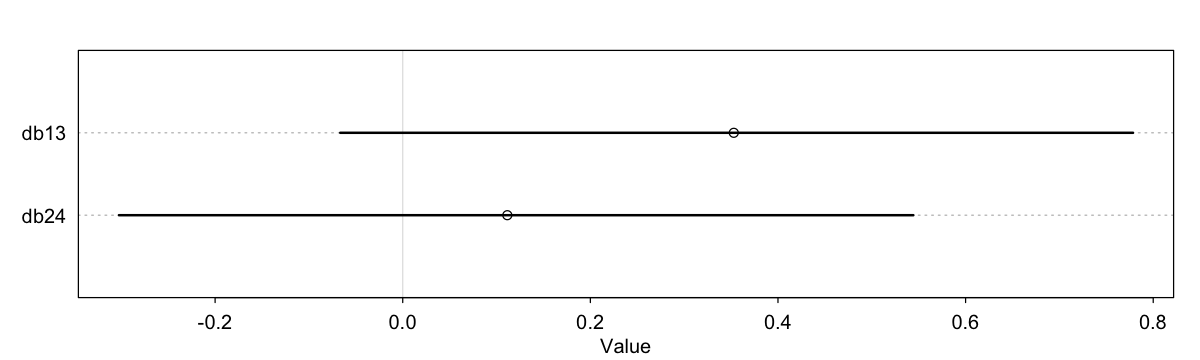

In [35]:
diffs <- list(
    db13 = post$b[, 1] - post$b[, 3],
    db24 = post$b[, 2] - post$b[, 4]
)
plot(precis(diffs))

**db13:** difference between partner/no-partner when prosocial option was on the left  
**db24:** difference between partner/no-partner when prosocial option was on the right

#### Posterior predictive checks

In [36]:
pl <- by(d$pulled_left, list(d$actor, d$treatment), mean)

In [45]:
pl[1, ]

1         2         3         4 
0.3333333 0.5000000 0.2777778 0.5555556

#### Model without interaction

We model the probability that a chimp used the left lever. The probability function is additive and consists of an actor specific part (probability with which a specific chimp uses the left lever in general), the placement of the prosocial option (probability with which the prosocial option is chosen) and the presence of a peer (probability that the left lever is pulled in the presence of another chimp)

In [46]:
d$side <- d$prosoc_left + 1
d$cond <- d$condition + 1

In [48]:
dat_list2 <- list(
    pulled_left = d$pulled_left,
    actor=d$actor,
    side=d$side,
    cond=d$cond
)
m11.5 <- ulam(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p) <- a[actor] + bs[side] + bc[cond],
        a[actor] ~ dnorm(0, 1.5),
        bs[side] ~ dnorm(0, 0.5),
        bc[cond] ~ dnorm(0, 0.5)
        ), data=dat_list2, chains=4, log_lik=TRUE
)


SAMPLING FOR MODEL '8cec853a8473faa0bc2e49bbbdc68fa7' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000103 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.03 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:   1 / 1000 [  0%]  (Warmup)
Chain 1: Iteration: 100 / 1000 [ 10%]  (Warmup)
Chain 1: Iteration: 200 / 1000 [ 20%]  (Warmup)
Chain 1: Iteration: 300 / 1000 [ 30%]  (Warmup)
Chain 1: Iteration: 400 / 1000 [ 40%]  (Warmup)
Chain 1: Iteration: 500 / 1000 [ 50%]  (Warmup)
Chain 1: Iteration: 501 / 1000 [ 50%]  (Sampling)
Chain 1: Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain 1: Iteration: 700 / 1000 [ 70%]  (Sampling)
Chain 1: Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain 1: Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain 1: Iteration: 1000 / 1000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.956785 seconds (Warm-up)
Chain 1:                0.866696 seconds (Sampling)
Chain 1:  

##### Comparing predictive ability

In [50]:
round(compare(m11.4, m11.5, func=PSIS), 2)

,PSIS,SE,dPSIS,dSE,pPSIS,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m11.5,530.59,19.18,0.00,NA,7.70,0.69
m11.4,532.17,18.97,1.57,1.32,8.49,0.31


The models with and without interaction are almost identical in terms of predictive capability.

#### Relative effects

Previously we looked at absolute effect sizes. So we analyzed the absolute change in probability when switching between treatments. As absolute effect sizes depend on the starting point on the logit function, it is common to provide effect sizes in relative terms as the factor remains constant.

In [51]:
post <- extract.samples(m11.4)
mean(exp(post$b[, 4]- post$b[,2]))

[1] 0.9275437

These are the proportional odds of switching from treatment 2 to treatment 4, which means we add a partner to the experiment. It means, that the switch multiplies the odds by 0.92 which is an 8% reduction. 

## Aggregated binomial

So far, we modeled the probability of a single lever pull, because the data was organized in a way that we looked at individual pulls. However, the data could also be given in aggregated format.

In [52]:
data(chimpanzees)
d <- chimpanzees
d$treatment  <- 1 + d$prosoc_left + 2 * d$condition
d$side <- d$prosoc_left + 1
d$cond <- d$condition + 1

In [53]:
d_aggregated <- aggregate(d$pulled_left, 
                         list(
                             treatment=d$treatment, actor=d$actor, side=d$side, cond=d$cond
                         ), sum)
colnames(d_aggregated)[5] <- "left_pulls"

In [55]:
head(d_aggregated)

,treatment,actor,side,cond,left_pulls
,<dbl>,<int>,<dbl>,<dbl>,<int>
1,1,1,1,1,6
2,1,2,1,1,18
3,1,3,1,1,5
4,1,4,1,1,6
5,1,5,1,1,6
6,1,6,1,1,14


In [56]:
dat <- with(d_aggregated, list(
    left_pulls = left_pulls,
    treatment = treatment,
    actor = actor, 
    side = side, 
    cond = cond
))

m11.6 <- ulam(
    alist(
        left_pulls ~ dbinom(18, p),
        logit(p) <- a[actor] + b[treatment],
        a[actor] ~ dnorm(0, 1.5),
        b[treatment] ~ dnorm(0, 0.5)
    ), data=dat, chains=4, log_lik=TRUE
)


SAMPLING FOR MODEL '79cee3368c3337e807538171c896ad26' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 3.1e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:   1 / 1000 [  0%]  (Warmup)
Chain 1: Iteration: 100 / 1000 [ 10%]  (Warmup)
Chain 1: Iteration: 200 / 1000 [ 20%]  (Warmup)
Chain 1: Iteration: 300 / 1000 [ 30%]  (Warmup)
Chain 1: Iteration: 400 / 1000 [ 40%]  (Warmup)
Chain 1: Iteration: 500 / 1000 [ 50%]  (Warmup)
Chain 1: Iteration: 501 / 1000 [ 50%]  (Sampling)
Chain 1: Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain 1: Iteration: 700 / 1000 [ 70%]  (Sampling)
Chain 1: Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain 1: Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain 1: Iteration: 1000 / 1000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.053056 seconds (Warm-up)
Chain 1:                0.047738 seconds (Sampling)
Chain 1:   

In [57]:
compare(m11.6, m11.4, func=PSIS)

Warning message in compare(m11.6, m11.4, func = PSIS):
“Different numbers of observations found for at least two models.
Model comparison is valid only for models fit to exactly the same observations.
Number of observations for each model:
m11.6 28 
m11.4 504 
”
Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.



,PSIS,SE,dPSIS,dSE,pPSIS,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m11.6,114.1414,8.456503,0.0000,NA,8.403676,1.000000e+00
m11.4,532.1668,18.973287,418.0254,9.49033,8.488602,1.686287e-91


The warning that counts of observations differ logically arise as we first modeled individual lever pulls and now model aggregated counts of levers. However, as the sets of data express the same facts, we can safely compare both models here.

PSIS scores are very different. This is because in model m11.6 there are more ways to see the data as in m11.4. So PSIS scores will be smaller.

The bottom line here is that the logistic format is preferrable when we want to calculate PSIS and WAIC.

## What to do when counts differ per category

In [58]:
data(UCBadmit)
d <- UCBadmit

In [59]:
d

,dept,applicant.gender,admit,reject,applications
,<fct>,<fct>,<int>,<int>,<int>
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191


In [62]:
dat_list <- list(
    admit = d$admit, 
    applications = d$applications,
    gid = ifelse(d$applicant.gender=="male", 1, 2)
)

m11.7 <- ulam(
    alist(
        admit ~ dbinom(applications, p),
        logit(p) <- a[gid],
        a[gid] ~ dnorm(0, 1.5)
    ), data=dat_list, chains=4
)
precis(m11.7, depth=2)


SAMPLING FOR MODEL '92bf1800293ab05bf80648b931ab8346' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.8e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:   1 / 1000 [  0%]  (Warmup)
Chain 1: Iteration: 100 / 1000 [ 10%]  (Warmup)
Chain 1: Iteration: 200 / 1000 [ 20%]  (Warmup)
Chain 1: Iteration: 300 / 1000 [ 30%]  (Warmup)
Chain 1: Iteration: 400 / 1000 [ 40%]  (Warmup)
Chain 1: Iteration: 500 / 1000 [ 50%]  (Warmup)
Chain 1: Iteration: 501 / 1000 [ 50%]  (Sampling)
Chain 1: Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain 1: Iteration: 700 / 1000 [ 70%]  (Sampling)
Chain 1: Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain 1: Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain 1: Iteration: 1000 / 1000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.011327 seconds (Warm-up)
Chain 1:                0.011401 seconds (Sampling)
Chain 1:   

,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a[1],-0.2195142,0.04069631,-0.2843486,-0.1544261,1189.352,1.001075
a[2],-0.8309767,0.05157106,-0.9120462,-0.7448200,1240.281,0.999366


In [63]:
post <- extract.samples(m11.7)
diff_a <- post$a[, 1] - post$a[, 2]
diff_p <- inv_logit(post$a[, 1]) - inv_logit(post$a[, 2])
precis(list(diff_a=diff_a, diff_p=diff_p))

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
diff_a,0.6114625,0.06690718,0.5029467,0.7178348,▁▁▃▇▇▅▂▁▁
diff_p,0.1418142,0.01510408,0.1168673,0.1659556,▁▁▂▃▇▇▅▂▁▁▁


Log-odds are certainly positive, which means as a male applicant it its more likely to be accepted. In absolute figures, the probability difference is somewhere between 12 and 16%.

#### considering department differences

In [72]:
dat_list <- list(
    admit = d$admit, 
    applications = d$applications,
    gid = ifelse(d$applicant.gender=="male", 1, 2),
    dept = as.integer(d$dept)

)
m11.7b <- ulam(
    alist(
        admit ~ dbinom(applications, p),
        logit(p) <- a[gid] + b[dept],
        a[gid] ~ dnorm(0, 1.5), 
        b[dept] ~ dnorm(0, 1.5)
    ), data=dat_list, chains=4, iter=4000
)


SAMPLING FOR MODEL '5c308870ea8199c34ca2315d3767c603' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.4e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 4000 [  0%]  (Warmup)
Chain 1: Iteration:  400 / 4000 [ 10%]  (Warmup)
Chain 1: Iteration:  800 / 4000 [ 20%]  (Warmup)
Chain 1: Iteration: 1200 / 4000 [ 30%]  (Warmup)
Chain 1: Iteration: 1600 / 4000 [ 40%]  (Warmup)
Chain 1: Iteration: 2000 / 4000 [ 50%]  (Warmup)
Chain 1: Iteration: 2001 / 4000 [ 50%]  (Sampling)
Chain 1: Iteration: 2400 / 4000 [ 60%]  (Sampling)
Chain 1: Iteration: 2800 / 4000 [ 70%]  (Sampling)
Chain 1: Iteration: 3200 / 4000 [ 80%]  (Sampling)
Chain 1: Iteration: 3600 / 4000 [ 90%]  (Sampling)
Chain 1: Iteration: 4000 / 4000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.279697 seconds (Warm-up)
Chain 1:                0.291217 seconds (Sampling)


In [73]:
round(precis(m11.7b, depth=2), 2)

,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a[1],-0.51,0.54,-1.37,0.34,656.68,1
a[2],-0.42,0.54,-1.28,0.44,654.70,1
b[1],1.10,0.54,0.24,1.96,661.52,1
b[2],1.05,0.54,0.19,1.92,666.50,1
b[3],-0.17,0.54,-1.03,0.70,663.58,1
b[4],-0.20,0.54,-1.06,0.66,655.51,1
b[5],-0.64,0.55,-1.51,0.24,670.82,1
b[6],-2.19,0.56,-3.08,-1.30,673.35,1


In [77]:
dat_list <- list(
    admit = d$admit, 
    applications = d$applications,
    gid = ifelse(d$applicant.gender=="male", 1, 2),
    dept = as.integer(d$dept),
    dept_id = rep(1:6, each=2)

)
m11.8 <- ulam(
    alist(
        admit ~ dbinom(applications, p),
        logit(p) <- a[gid] + delta[dept_id],
        a[gid] ~ dnorm(0, 1.5), 
        delta[dept_id] ~ dnorm(0, 1.5)
    ), data=dat_list, chains=4, iter=4000
)

recompiling to avoid crashing R session




SAMPLING FOR MODEL 'debd3ec961c3602eb19177c1555512ff' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.4e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 4000 [  0%]  (Warmup)
Chain 1: Iteration:  400 / 4000 [ 10%]  (Warmup)
Chain 1: Iteration:  800 / 4000 [ 20%]  (Warmup)
Chain 1: Iteration: 1200 / 4000 [ 30%]  (Warmup)
Chain 1: Iteration: 1600 / 4000 [ 40%]  (Warmup)
Chain 1: Iteration: 2000 / 4000 [ 50%]  (Warmup)
Chain 1: Iteration: 2001 / 4000 [ 50%]  (Sampling)
Chain 1: Iteration: 2400 / 4000 [ 60%]  (Sampling)
Chain 1: Iteration: 2800 / 4000 [ 70%]  (Sampling)
Chain 1: Iteration: 3200 / 4000 [ 80%]  (Sampling)
Chain 1: Iteration: 3600 / 4000 [ 90%]  (Sampling)
Chain 1: Iteration: 4000 / 4000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.276693 seconds (Warm-up)
Chain 1:                0.281607 seconds (Sampling)


In [78]:
round(precis(m11.8, depth=2), 2)

,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a[1],-0.54,0.55,-1.42,0.34,453.79,1.01
a[2],-0.44,0.55,-1.32,0.44,456.77,1.01
delta[1],1.12,0.55,0.25,1.99,458.34,1.01
delta[2],1.07,0.56,0.19,1.96,458.23,1.01
delta[3],-0.14,0.55,-1.03,0.75,457.25,1.01
delta[4],-0.18,0.55,-1.06,0.72,459.32,1.01
delta[5],-0.62,0.56,-1.50,0.27,458.74,1.00
delta[6],-2.18,0.57,-3.07,-1.29,482.63,1.01


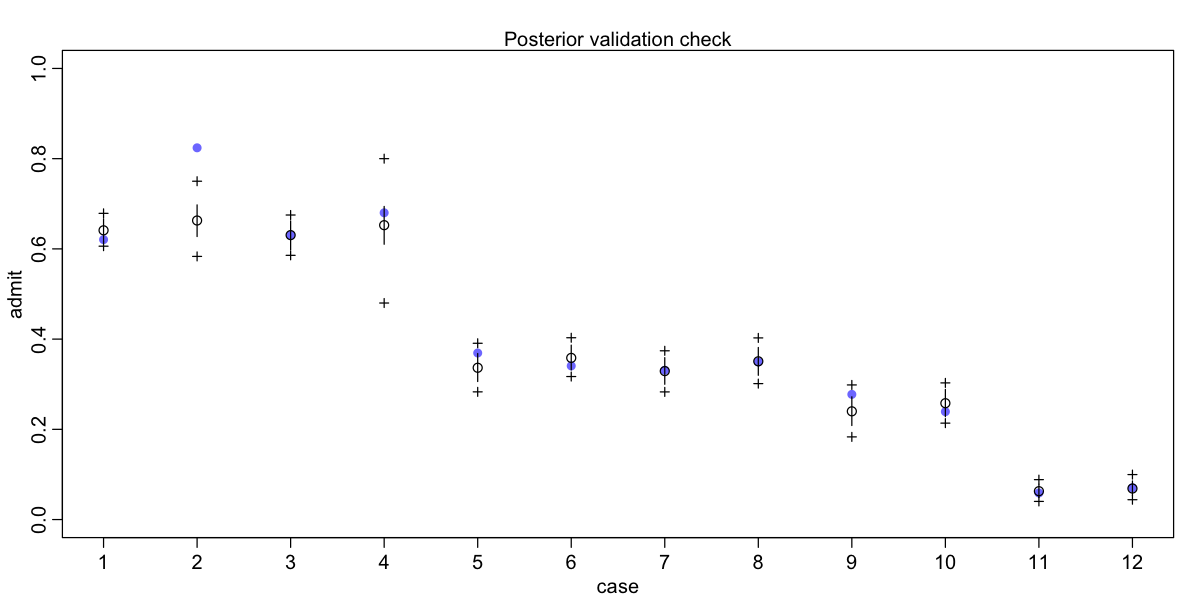

In [82]:
options(repr.plot.width=10, repr.plot.height=5)
postcheck(m11.8)

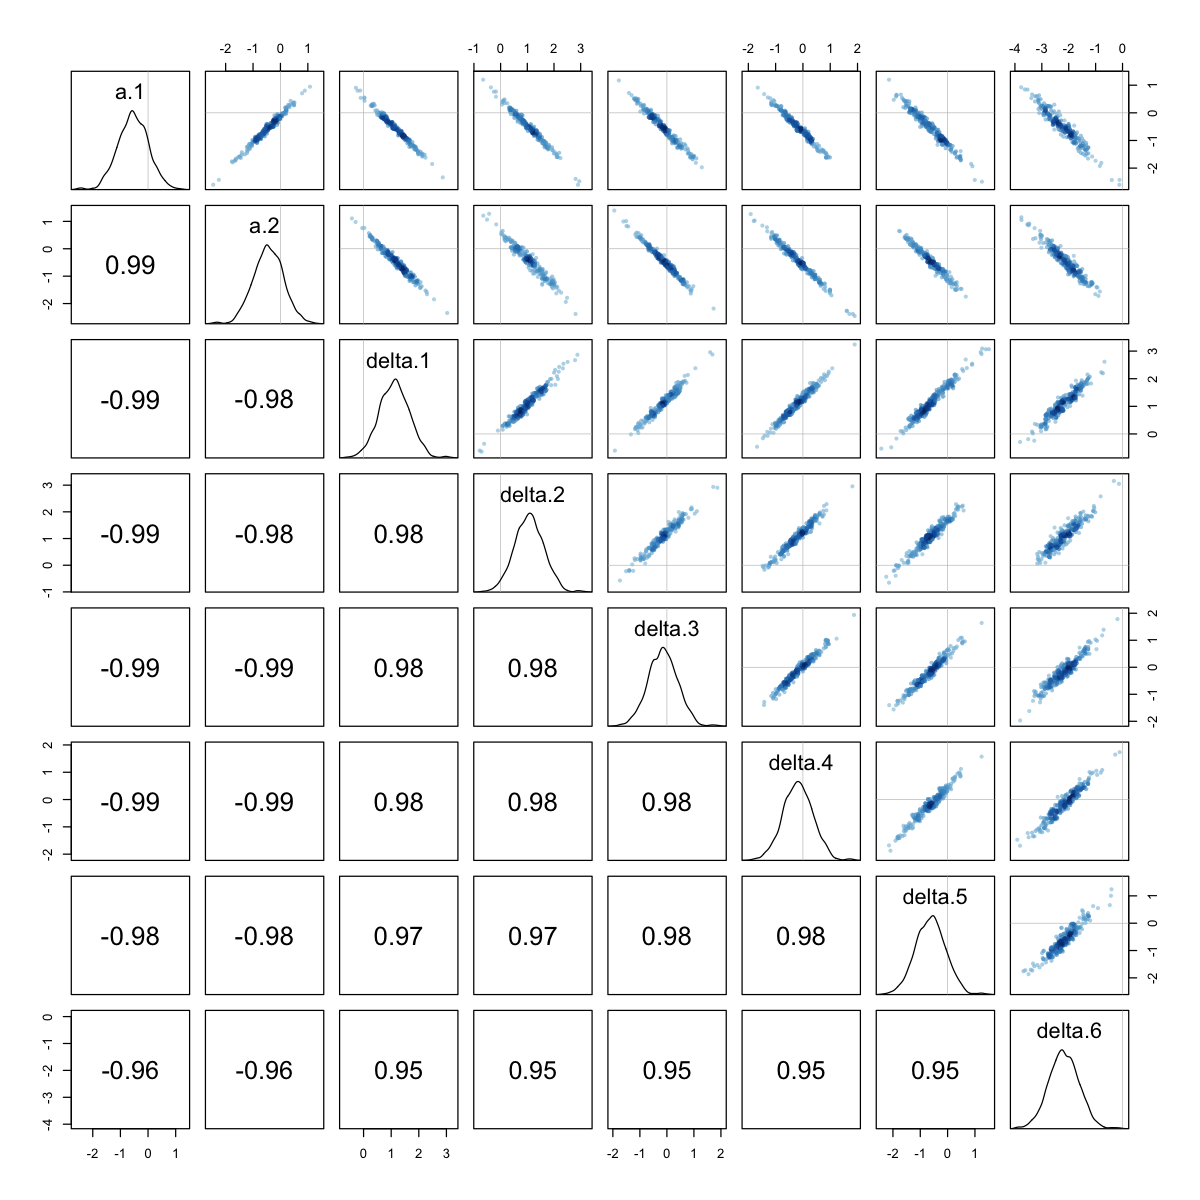

In [84]:
options(repr.plot.width=10, repr.plot.height=10)
pairs(m11.8)